<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Clean-Character-Data" data-toc-modified-id="Load-Clean-Character-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Clean Character Data</a></span></li><li><span><a href="#Fit-Baseline-DCGAN-(Unconditional)" data-toc-modified-id="Fit-Baseline-DCGAN-(Unconditional)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit Baseline DCGAN (Unconditional)</a></span></li><li><span><a href="#Fit-Baseline-Conditional-DCGAN-on-'a's-and-'j's" data-toc-modified-id="Fit-Baseline-Conditional-DCGAN-on-'a's-and-'j's-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit Baseline Conditional DCGAN on 'a's and 'j's</a></span></li></ul></div>

## Load Clean Character Data

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import tensorflow
from tensorflow.python.keras.layers import Input, Reshape, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Concatenate
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.layers.core import Dense, Dropout
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import initializers

In [77]:
tensorflow.config.run_functions_eagerly(True)

In [20]:
#import clean 'j' and 'a' chars from EDA Phase
j_char_matrix = np.load('j_chars.npy')
a_char_matrix = np.load('a_chars.npy')

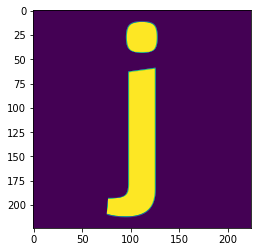

In [3]:
first_j = j_char_matrix[0]
plt.imshow(first_j)
plt.show()

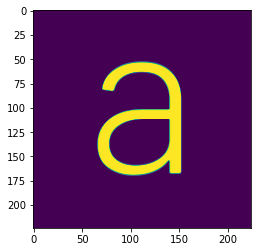

In [3]:
first_a = a_char_matrix[0]
plt.imshow(first_a)
plt.show()

In [4]:
print(first_a.shape)
print(a_char_matrix.shape)

(224, 224, 1)
(3631, 224, 224, 1)


## Fit Baseline DCGAN (Unconditional)

In [20]:
#define discriminator model
def define_discriminator(in_shape=(224, 224, 1)):
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    #Downsample again
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    #Classify
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    #Compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
#define generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128*56*56
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((56, 56, 128)))
    #upsample
    model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    #upsample again
    model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    #generate
    model.add(Conv2D(1, kernel_size=(4, 4), activation='tanh'))
    return model

In [14]:
#define combined generator and discriminator
def define_gan(generator, descriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    #compile
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [30]:
def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = np.ones((n_samples, 1))
    return X, y

In [9]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [39]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [13]:
def show_plot(examples, n):
    figure(figsize=(15, 15))
    for i in range(n * n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

In [42]:
#train generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, filename, n_epochs=100, n_batch=16):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            #summarize loss
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss_2, g_loss))
    #save generator
    g_model.save('{}.h5'.format(filename))

In [43]:
#test with 'a' characters
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = a_char_matrix

In [ ]:
#trained in Google Colab to leverage GPU
train(generator, discriminator, gan_model, dataset, latent_dim, 'a_generator')

**Train Screenshot from Google Colab**
<img src="images/GAN_train_a.png">

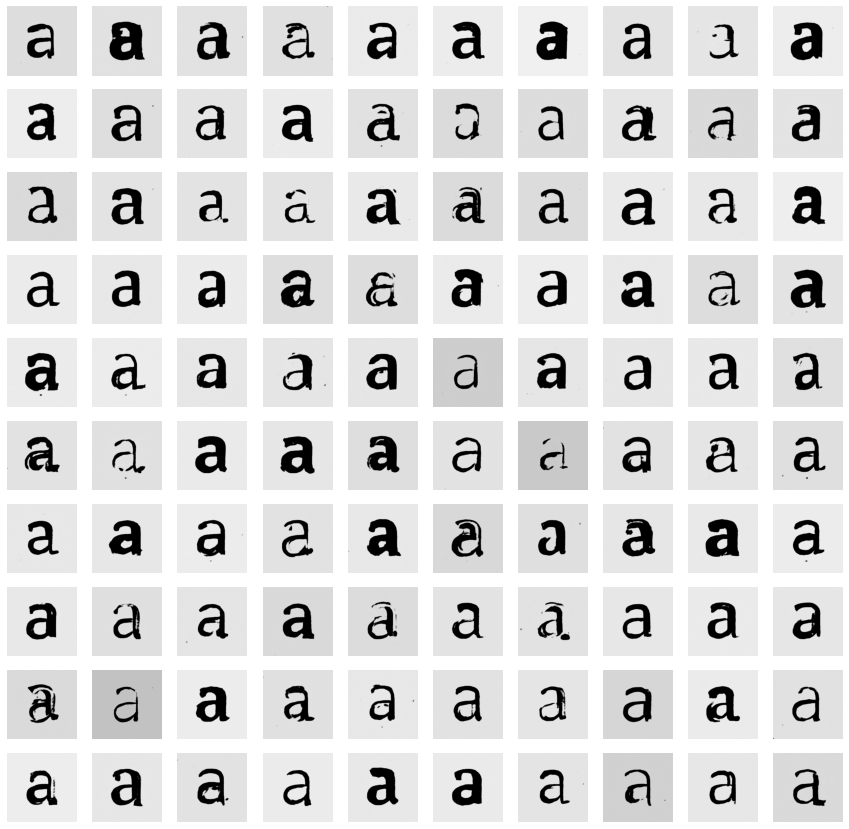

In [14]:
#load model
model = load_model('a_generator.h5')
#generate images
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)

These are looking pretty good!  
Will try training for 300 epochs on the 'j's to see if there is a difference.

In [ ]:
#trained in Google Colab to leverage GPU
train(generator, discriminator, gan_model, dataset, latent_dim, 'j_generator', n_epochs=300)

**Train Screenshot from Google Colab**
<img src="images/GAN_train_j.png">

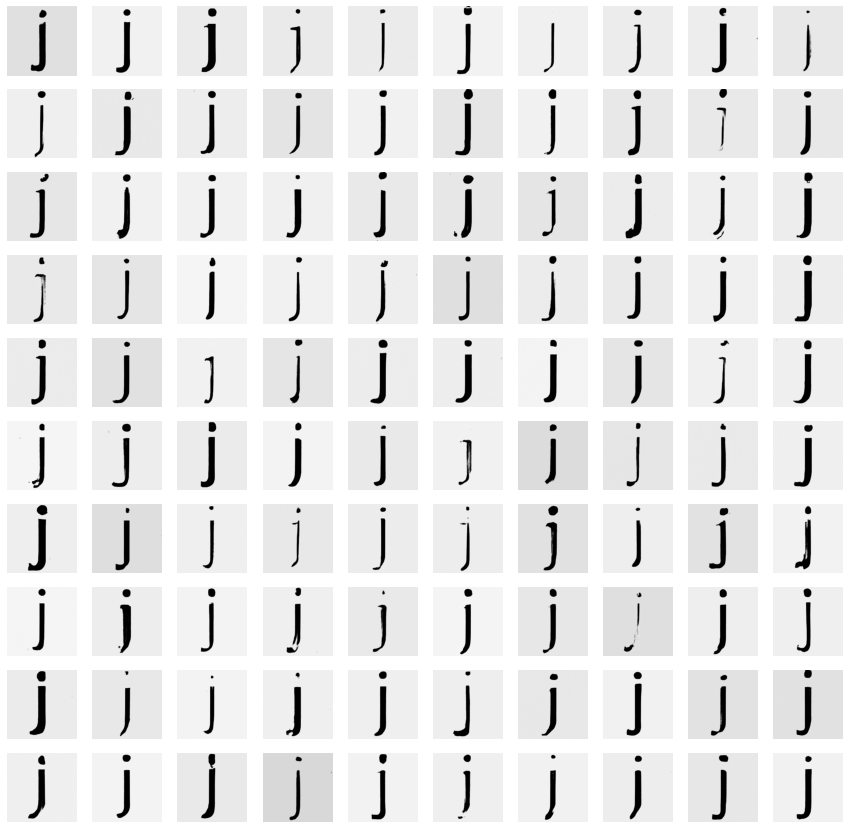

In [16]:
#load model
model = load_model('j_generator.h5')
#generate images
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)

Looking good!  
Now to train a conditional GAN on these two character.  
If all goes well, I will expand to the rest of the characters.

## Fit Baseline Conditional DCGAN on 'a's and 'j's

In [124]:
#class order constant
class_folders = ['Uu','Yy','Pp','Bb','Nn','Gg','Kk','Ii','Ee','Ll','r','u','9','0','7','Rr','i','n','g','6','z','1','8','t','s','a','f','o','h','Ww','Ss','Vv','Zz','Dd','Hh','Aa','Mm','Oo','Cc','Jj','Ff','m','j','c','Xx','Tt','d','v','q','4','x','3','e','b','k','l','2','y','5','p','Qq','w']

In [153]:
def define_conditional_discriminator(in_shape=(224, 224, 1), n_classes=2):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 76)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    in_image = Input(shape=in_shape)
    #concatenate with class label
    merge = Concatenate()([in_image, li])
    fe = Conv2D(128, kernel_size=(3, 3), strides=(2,2))(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, kernel_size=(3, 3), strides=(2,2))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.25)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model([in_image, in_label], out_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [154]:
def define_conditional_generator(latent_dim, n_classes=2):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 76)(in_label)
    n_nodes = 56*56
    li = Dense(n_nodes)(li)
    li = Reshape((56, 56, 1))(li)
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 56 * 56
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((56, 56, 128))(gen)
    merge = Concatenate()([gen, li])
    gen = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2))(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2))(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Conv2D(1, kernel_size=(4, 4), activation='tanh')(gen)
    model = Model([in_lat, in_label], out_layer)
    return model

In [155]:
def define_conditional_gan(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [156]:
def generate_conditional_real_samples(dataset, n_samples):
    images, labels = dataset
    idx = np.random.randint(0, images.shape[0], n_samples)
    X, labels = images[idx], labels[idx]
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [157]:
def generate_conditional_latent_points(latent_dim, n_samples, n_classes=2):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [158]:
def generate_conditional_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_conditional_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [159]:
def train_conditional(g_model, d_model, gan_model, dataset, latent_dim, filename, n_epochs=100, n_batch=16):
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            [X_real, labels_real], y_real = generate_conditional_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels_fake], y_fake = generate_conditional_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_conditional_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    g_model.save('{}.h5'.format(filename))

In [167]:
# create and save a plot of generated images
def show_conditional_plot(examples, n):
    # plot images
    figure(figsize=(15, 15))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

In [161]:
#test with 'a' and 'j' characters
latent_dim = 100
discriminator = define_conditional_discriminator()
generator = define_conditional_generator(latent_dim)
gan_model = define_conditional_gan(generator, discriminator)

In [162]:
#define classes as one-hots
#a:0, j:1
a_labels = np.array([0] * 3631)
j_labels = np.array([1] * 3570)
print(a_labels.shape)
print(a_char_matrix.shape)

#create dataset
X = np.append(a_char_matrix, j_char_matrix, axis=0)
y = np.append(a_labels, j_labels, axis=0)

print(X.shape)
print(y.shape)

(3631,)
(3631, 224, 224, 1)
(7201, 224, 224, 1)
(7201,)


In [163]:
dataset = [X, y]

In [ ]:
train_conditional(generator, discriminator, gan_model, dataset, latent_dim, 'conditional_test', n_epochs=2)

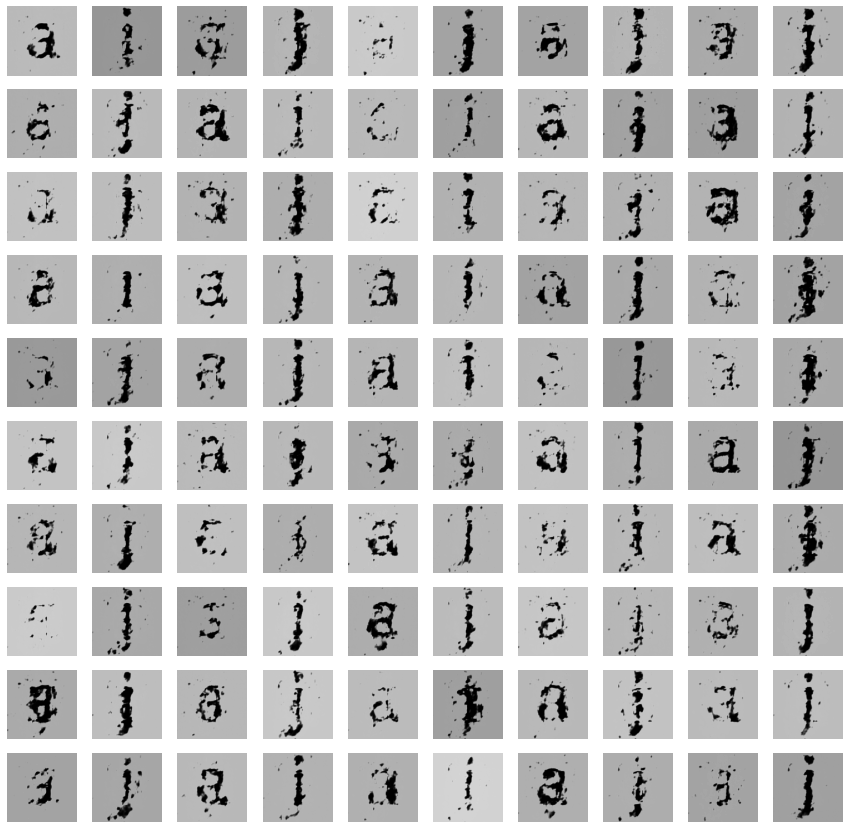

In [168]:
# load model after 2 epochs
model = load_model('conditional_test.h5')

# generate images
latent_points, labels = generate_conditional_latent_points(100, 100)
# specify labels (alternating 'a's and 'j's)
labels = np.asarray([x for _ in range(50) for x in range(2)]) #Remember to update when number of classes changes
# generate images
Xc  = model.predict([latent_points, labels])
# plot the result
show_conditional_plot(Xc, 10)

Not bad for 2 epochs.  
Will migrate to Google colab to train further, then bring in the remaining classes to train and rerun once more.

In [ ]:
#trained on Colab to utilize GPU
train_conditional(generator, discriminator, gan_model, dataset, latent_dim, 'conditional_test', n_epochs=50)

**Train Screenshot from Google Colab (50 Epochs)**
<img src="images/GAN_train_cgan50.png">

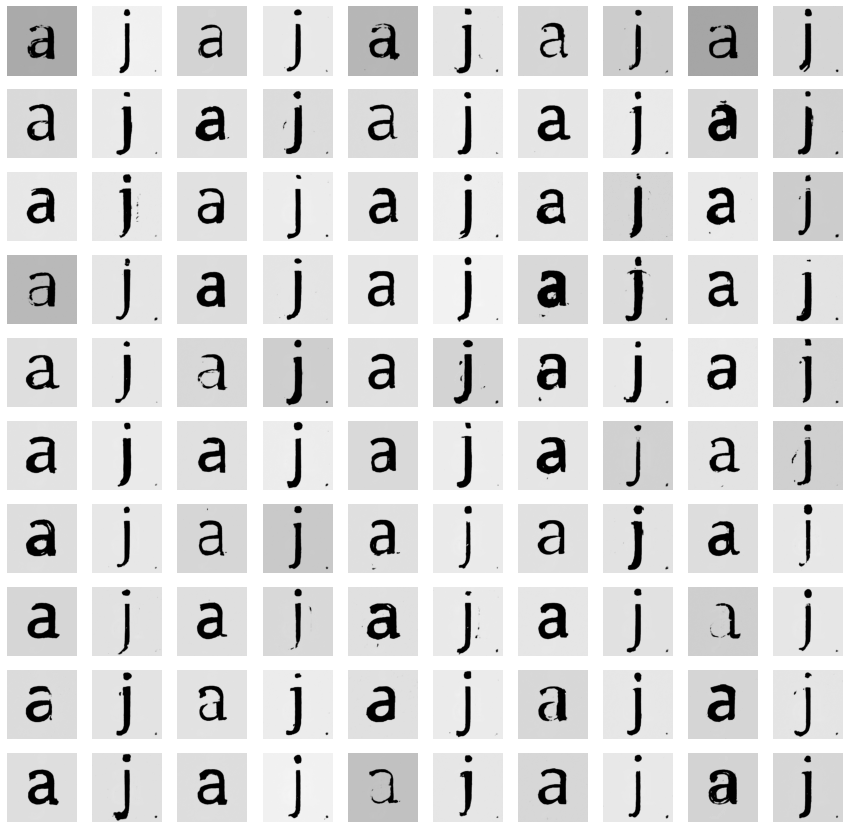

In [171]:
# load model after 50 epochs
model = load_model('conditional_test50.h5')

# generate images
latent_points, labels = generate_conditional_latent_points(100, 100)
# specify labels (alternating 'a's and 'j's)
labels = np.asarray([x for _ in range(50) for x in range(2)]) #Remember to update when number of classes changes
# generate images
Xc  = model.predict([latent_points, labels])
# plot the result
show_conditional_plot(Xc, 10)

Much better.  
Also appears that the pairs roughtly belong together.  
I can observe bolder 'a's paired with bolder 'j's etc, which is a good sign the latent spaces are similar for these characters.  
**Next Steps:**
I will use this on the 62 character set, train a bit further, and tweak the output code to generate a baseline typeace.